In [1]:
import pandas as pd
import numpy as np

from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression

def rmse(y_true, y_pred):
    return mean_squared_error(y_true, y_pred) ** 0.5

# -----------------------
# 1) Load + scope
# -----------------------
df = pd.read_csv("retail_store_inventory.csv")

df = df[(df["Region"] == "North") & (df["Category"] == "Groceries")].copy()
df["Date"] = pd.to_datetime(df["Date"])

# Product별 시간 순 정렬 (Lag 필수)
df = df.sort_values(["Product ID", "Date"]).reset_index(drop=True)

# -----------------------
# 2) Lag features (임시)
# -----------------------
df["lag_1"] = df.groupby("Product ID")["Units Sold"].shift(1)
df["rolling_7_mean"] = (
    df.groupby("Product ID")["Units Sold"]
      .shift(1)
      .rolling(7)
      .mean()
      .reset_index(level=0, drop=True)
)

# Lag로 인해 생긴 결측 제거
df = df.dropna(subset=["lag_1", "rolling_7_mean"]).copy()

# -----------------------
# 3) Date features
# -----------------------
df["DayOfWeek"] = df["Date"].dt.day_name()
df["Month"] = df["Date"].dt.month.astype(int)

# -----------------------
# 4) Time-based Train/Test split
# -----------------------
split_idx = int(len(df) * 0.8)
train = df.iloc[:split_idx].copy()
test  = df.iloc[split_idx:].copy()

y_train = train["Units Sold"]
y_test  = test["Units Sold"]

# -----------------------
# 5) Features
# -----------------------
numeric_features = [
    "Inventory Level",
    "Price",
    "Discount",
    "Competitor Pricing",
    "lag_1",
    "rolling_7_mean"
]

categorical_features = [
    "Weather Condition",
    "Holiday/Promotion",
    "Seasonality",
    "DayOfWeek",
    "Month"
]

X_train = train[numeric_features + categorical_features]
X_test  = test[numeric_features + categorical_features]

# -----------------------
# 6) Preprocess + Linear Regression
# -----------------------
preprocess = ColumnTransformer([
    ("num", StandardScaler(), numeric_features),
    ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features)
])

model = Pipeline([
    ("preprocess", preprocess),
    ("lr", LinearRegression())
])

# -----------------------
# 7) Train + Predict
# -----------------------
model.fit(X_train, y_train)
pred = model.predict(X_test)

# -----------------------
# 8) Evaluate
# -----------------------
print("Lag-based Linear Regression")
print("RMSE:", rmse(y_test, pred))
print("MAE :", mean_absolute_error(y_test, pred))

Lag-based Linear Regression
RMSE: 87.95495363042231
MAE : 68.44517399418787


In [2]:
lag_compare = pd.DataFrame({
    "Version": ["LR (No Lag)", "LR (With Lag)"],
    "RMSE": [89.20, 87.95],
    "MAE": [69.15, 68.45]
})

lag_compare.to_csv("lr_lag_comparison2.csv", index=False)

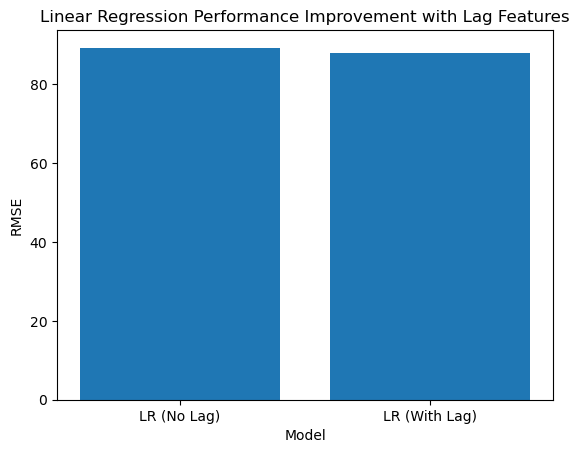

In [4]:
import matplotlib.pyplot as plt

models = ['LR (No Lag)', 'LR (With Lag)']
rmse = [89.20, 87.95]   # ← 네가 이미 얻은 실제 값으로 수정

plt.bar(models, rmse)
plt.title('Linear Regression Performance Improvement with Lag Features')
plt.ylabel('RMSE')
plt.xlabel('Model')
plt.show()

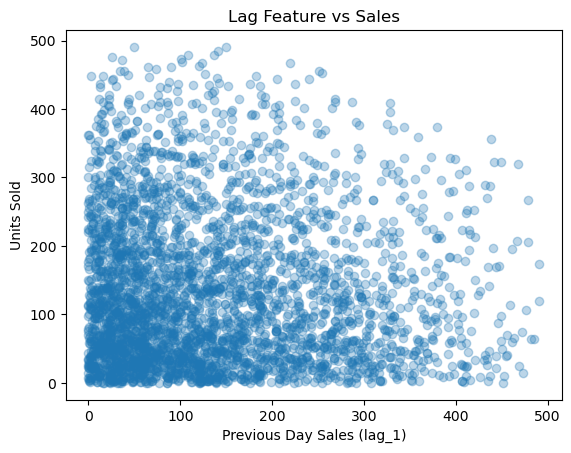

In [6]:
plt.scatter(df['lag_1'], df['Units Sold'], alpha=0.3)
plt.xlabel('Previous Day Sales (lag_1)')
plt.ylabel('Units Sold')
plt.title('Lag Feature vs Sales')
plt.show()